Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
数据文件夹存在: /scratch/gpfs/sl3965/datasets/perp_futures_klines
找到 341 个 parquet 文件
正在读取数据文件...


  0%|          | 0/341 [00:00<?, ?it/s]

合并所有数据...
数据预览:
            open_time     open     high      low    close    volume  count  \
0 2025-01-01 00:00:00  0.19955  0.19959  0.19916  0.19959  140561.0  259.0   
1 2025-01-01 00:01:00  0.19960  0.19986  0.19952  0.19986   50449.0  146.0   
2 2025-01-01 00:02:00  0.19988  0.20033  0.19986  0.20033   89781.0  170.0   
3 2025-01-01 00:03:00  0.20037  0.20077  0.20037  0.20052  509099.0  477.0   
4 2025-01-01 00:04:00  0.20052  0.20095  0.20052  0.20074  166762.0  256.0   

    symbol  
0  GRTUSDT  
1  GRTUSDT  
2  GRTUSDT  
3  GRTUSDT  
4  GRTUSDT  

数据信息:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43897380 entries, 0 to 43897379
Data columns (total 8 columns):
 #   Column     Dtype         
---  ------     -----         
 0   open_time  datetime64[ns]
 1   open       float64       
 2   high       float64       
 3   low        float64       
 4   close      float64       
 5   volume     float64       
 6   count      float64       
 7   symbol     object        
dtypes

/home/sl3965/zyh/my-pyepo/my-PyEPO/00_portfolio_real_data/io_utils.py:135: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/sl3965/zyh/my-pyepo/my-PyEPO/00_portfolio_real_data/io_utils.py:135: UserWarning: Glyph 25454 (\N{CJK UNIFIED IDEOGRAPH-636E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/sl3965/zyh/my-pyepo/my-PyEPO/00_portfolio_real_data/io_utils.py:135: UserWarning: Glyph 28857 (\N{CJK UNIFIED IDEOGRAPH-70B9}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/sl3965/zyh/my-pyepo/my-PyEPO/00_portfolio_real_data/io_utils.py:135: UserWarning: Glyph 21508 (\N{CJK UNIFIED IDEOGRAPH-5404}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/sl3965/zyh/my-pyepo/my-PyEPO/00_portfolio_real_data/io_utils.py:135: UserWarning: Glyph 20132 (\N{CJK UNIFIED IDEOGRAPH-4EA4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/sl3965/zyh/my-pyepo/my-PyEPO/00_portfolio_real_data/io

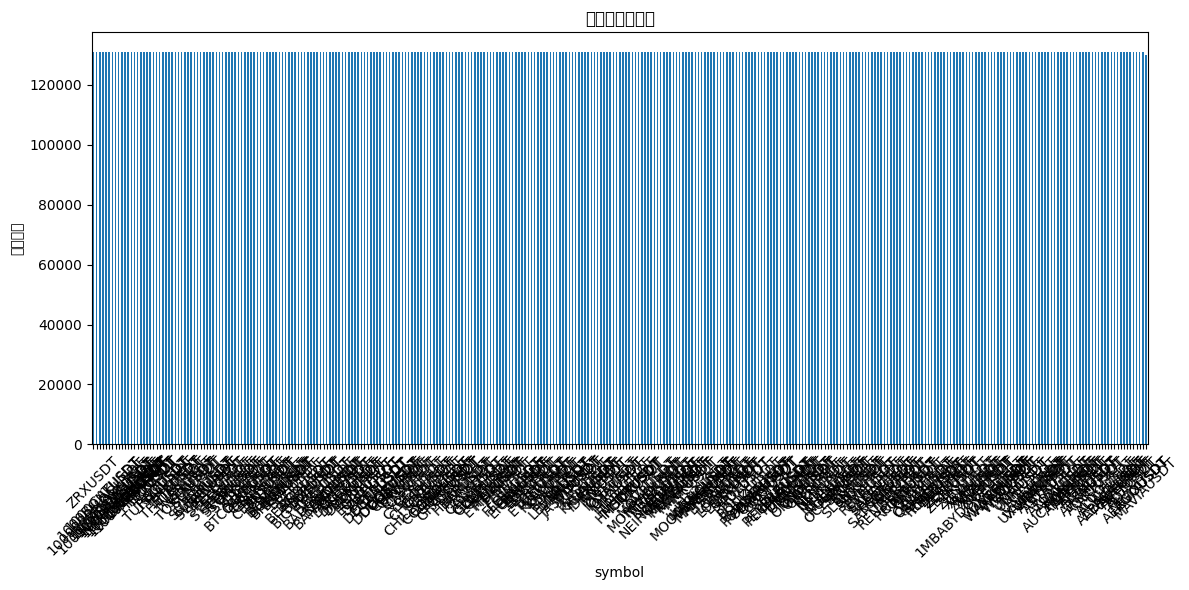


特征统计信息:
               open          high           low         close        volume  \
count  4.388733e+07  4.388733e+07  4.388733e+07  4.388733e+07  4.388733e+07   
mean   3.317370e+02  3.318920e+02  3.315807e+02  3.317367e+02  4.329441e+06   
std    5.123572e+03  5.125776e+03  5.121351e+03  5.123568e+03  1.114563e+08   
min    3.910000e-05  4.070000e-05  3.830000e-05  3.910000e-05  0.000000e+00   
25%    6.103700e-02  6.110000e-02  6.098000e-02  6.103000e-02  1.527300e+03   
50%    2.947000e-01  2.950000e-01  2.944000e-01  2.947000e-01  1.413100e+04   
75%    1.416000e+00  1.417600e+00  1.414600e+00  1.416000e+00  9.812000e+04   
max    1.095292e+05  1.100000e+05  1.090177e+05  1.095326e+05  2.503323e+11   

              count  
count  4.388733e+07  
mean   2.317585e+02  
std    7.077092e+02  
min    0.000000e+00  
25%    2.800000e+01  
50%    7.100000e+01  
75%    1.890000e+02  
max    1.589770e+05  

目标变量统计信息:
count    4.388733e+07
mean    -1.299447e-04
std      9.201710e-03
min 

6.153240203857422

In [1]:
from io_utils import process_perp_futures_data, save_optData, save_dataset_dict
from config import *
from data_utils import align_time_series_fast, GroupMinMaxScaler, pivot_features_and_costs
from batch_runner import process_and_combine_shared
from pyepo.data.dataset import optDataset
from model_factory import build_market_neutral_model,build_market_neutral_model_testing
import pandas as pd
import numpy as np
import os
from sklearn.decomposition import PCA
import pickle
import psutil
import gc
def split_train_test_by_time_quantile(df, time_col='open_time', frac=0.8):
    """
    按 time_col 的 frac 分位点来划分训练/测试集。

    参数
    -----
    df       : pandas.DataFrame
        包含时间列（或索引）的 DataFrame。
    time_col : str, optional
        时间列名，如果 df 已经用时间索引则设为 None。
    frac     : float, optional
        用于训练集的比例，默认 0.8（即前 80% 的时间）。

    返回
    -----
    train_df, test_df : pandas.DataFrame
    """
    # 如果 open_time 是列，就用那列；否则假设 df.index 是 DatetimeIndex
    if time_col is not None:
        times = pd.to_datetime(df[time_col])
    else:
        times = pd.to_datetime(df.index)

    # 计算 80% 分位的时间点
    cutoff = times.quantile(frac)

    # 划分
    if time_col is not None:
        train_df = df[times <= cutoff]
        test_df  = df[times  > cutoff]
    else:
        train_df = df[df.index <= cutoff]
        test_df  = df[df.index  > cutoff]

    return train_df, test_df

def print_memory(stage):
    """打印内存使用"""
    process = psutil.Process()
    memory_gb = process.memory_info().rss / (1024**3)
    print(f" {stage}: {memory_gb:.2f} GB")
    return memory_gb

#个人许可证
os.environ['GRB_LICENSE_FILE'] = os.path.expanduser("~/gurobi/gurobi.lic")




combined_df = process_perp_futures_data(data_path=RAW_DATA_PATH, output_path=PROCESSED_DATA_PATH)

print_memory("加载数据后")


aligned_df = align_time_series_fast(combined_df)
aligned_df.to_parquet(ALIGNED_CRYPTO_DATA_PATH)
print("时间对齐后的数据信息：")
print(aligned_df.shape)
print(aligned_df.head())
print_memory("加载对齐数据后")
print("\n  删除 combined_df...")
del combined_df  # 删除aligned_df和times
gc.collect()
print_memory("删除combined_df后")


### 划分训练集&测试集，open_time的前80%为训练集
train_df, test_df = split_train_test_by_time_quantile(aligned_df, time_col='open_time', frac=0.8)
print("Train 时间范围：", train_df['open_time'].min(), "—", train_df['open_time'].max())
print("Test  时间范围：",  test_df['open_time'].min(),  "—", test_df['open_time'].max())

print("\n  删除 aligned_df...")
del aligned_df
gc.collect()
print_memory("删除aligned_df后")




### 对训练集做scale和precompute，保存MarketNeutralModel和precomputed_train_optData
scaler = GroupMinMaxScaler(feature_range=(-1,1), target_columns=X_COLS, group_by_column='symbol')
print("对训练集做scale")
train_df = scaler.fit_transform(train_df)

print_memory("scale train_df 后")

print("pivot features and costs")
features, costs, unique_times, unique_symbols = pivot_features_and_costs(train_df, y_col=Y_COL, x_cols=X_COLS)
save_optData(features, costs, unique_times, unique_symbols, X_COLS, name=OPTDATA_NAME, save_dir=TRAIN_OPTDATA_DIR)
print_memory("pivot train_df 后")

del train_df
gc.collect()
print_memory("删除train_df后") 

N = features.shape[1] 
A = np.ones((1, N))
b = np.array([1.0])
l = np.zeros(N)
u = np.zeros(N) + 1e6
# 把cov_matrix修改为costs的covariance
##M = np.random.randn(N, N)
###cov_matrix = M.T @ M + np.eye(N) * 1e-3
cov_matrix = np.cov(costs, rowvar=False, bias=False)
# 把risk_f修改为第一主成分
## risk_f = np.random.randn(N)
pca = PCA(n_components=1)
risk_f = pca.fit_transform(cov_matrix).ravel()

risk_abs   = 1.5
single_abs = 0.1
l1_abs     = 1.0
sigma_abs  = 2.5
turnover   = 0.3

print("保存常规模型参数...")
params = dict(
    N=N, A=A, b=b, l=l, u=u,
    risk_f=risk_f, risk_abs=risk_abs,
    single_abs=single_abs, l1_abs=l1_abs,
    cov_matrix=cov_matrix, sigma_abs=sigma_abs
)
with open(MARKET_MODEL_DIR, "wb") as f:
    pickle.dump(params, f)

try:
    model = build_market_neutral_model(N, A, b, l, u, risk_f, risk_abs, single_abs, l1_abs, cov_matrix, sigma_abs)
    print("✓ 常规模型创建成功")
except Exception as e:
    print(f"✗ 常规模型创建失败: {e}")

# 保存测试模型参数（包含turnover）
print(" 保存测试模型参数...")
params_testing = dict(
    N=N, A=A, b=b, l=l, u=u,
    risk_f=risk_f, risk_abs=risk_abs,
    single_abs=single_abs, l1_abs=l1_abs,
    cov_matrix=cov_matrix, sigma_abs=sigma_abs, turnover=turnover
)
with open(MARKET_MODEL_DIR_TESTING, "wb") as f:
    pickle.dump(params_testing, f)

try:
    model_testing = build_market_neutral_model_testing(N, A, b, l, u, risk_f, risk_abs, single_abs, l1_abs, cov_matrix, sigma_abs, turnover)
    print("✓ 测试模型创建成功")
except Exception as e:
    print(f"✗ 测试模型创建失败: {e}")
"""
params = dict(
N=N, A=A, b=b, l=l, u=u,
risk_f=risk_f, risk_abs=risk_abs,
single_abs=single_abs, l1_abs=l1_abs,
cov_matrix=cov_matrix, sigma_abs=sigma_abs)
with open(MARKET_MODEL_DIR, "wb") as f:
    pickle.dump(params, f)
model = build_market_neutral_model(N, A, b, l, u, risk_f, risk_abs, single_abs, l1_abs, cov_matrix, sigma_abs)

params_testing = dict(
N=N, A=A, b=b, l=l, u=u,
risk_f=risk_f, risk_abs=risk_abs,
single_abs=single_abs, l1_abs=l1_abs,
cov_matrix=cov_matrix, sigma_abs=sigma_abs,turnover=turnover)
with open(MARKET_MODEL_DIR_TESTING, "wb") as f:
    pickle.dump(params_testing, f)
model_testing = build_market_neutral_model_testing(N, A, b, l, u, risk_f, risk_abs, single_abs, l1_abs, cov_matrix, sigma_abs, turnover)
"""


test_df = scaler.transform(test_df)
test_features, test_costs, _, _ = pivot_features_and_costs(test_df, y_col=Y_COL, x_cols=X_COLS)
os.makedirs(TEST_DATA_DIR, exist_ok=True)
np.save(f"{TEST_DATA_DIR}/features_{OPTDATA_NAME}.npy", test_features)
del test_df
gc.collect()
print_memory("删除test_df后") 


   


In [2]:
# General imports
import time
import pandas as pd
import numpy as np
import gc
from multiprocessing import get_context, shared_memory, Process

# Model imports
from model_factory import build_market_neutral_model,build_market_neutral_model_testing
from config import *

# PyEPO imports
from pyepo.data.dataset import optDataset

# Gurobi
import gurobipy as gp
from gurobipy import GRB
from pyepo.model.grb import optGrbModel

# Pyomo
from pyomo import environ as pe
from pyepo.model.omo import optOmoModel # 记得要把 omo 文件夹里的 __init__.py 文件也修改了
from pyepo import EPO

# COPTPy
from coptpy import Envr, COPT
from pyepo.model.copt import optCoptModel

# MPAX
from pyepo.model.mpax import optMpaxModel

# PCA
from sklearn.decomposition import PCA
import pickle

from batch_runner import run_batch_shared


os.environ['GRB_LICENSE_FILE'] = os.path.expanduser("~/gurobi/gurobi.lic")


def process_and_combine_shared(features, costs, batch_size=1000, N=None, A=None, b=None, l=None, u=None, risk_f=None, risk_abs=None, single_abs=None, l1_abs=None, cov_matrix=None, sigma_abs=None):
    ctx = get_context('spawn')
    total_samples = len(features)
    all_feats, all_sols, all_objs = [], [], []

    if N is None:
        N = features.shape[1] 
        A = np.ones((1, N))
        b = np.array([1.0])
        l = np.zeros(N)
        u = np.zeros(N) + 1e6
        # 把cov_matrix修改为costs的covariance
        ## M = np.random.randn(N, N)
        ## cov_matrix = M.T @ M + np.eye(N) * 1e-3
        cov_matrix = np.cov(costs, rowvar=False, bias=False)
        # 把risk_f修改为第一主成分
        ## risk_f = np.random.randn(N)
        pca = PCA(n_components=1)
        risk_f = pca.fit_transform(cov_matrix).ravel()
        
        risk_abs   = 1.5
        single_abs = 0.1
        l1_abs     = 1.0
        sigma_abs  = 2.5

    for i in range(0, total_samples, batch_size):
        start, end = i, min(i + batch_size, total_samples)
        print(f"\n 共享内存子进程处理样本 {start} 到 {end - 1}...")

        feats_batch = features[start:end]
        costs_batch = costs[start:end]

        shapes = {
            'feats': (feats_batch.shape[0], feats_batch.shape[1], LOOKBACK, feats_batch.shape[2]),
            'sols': (feats_batch.shape[0], feats_batch.shape[1]),
            'objs': (feats_batch.shape[0],1)
        }
        dtypes = {'feats': feats_batch.dtype, 'sols': np.float32, 'objs': np.float32}

        shms = {key: shared_memory.SharedMemory(create=True, size=np.zeros(shapes[key], dtype=dtypes[key]).nbytes)
                for key in shapes}

        shm_names = {k: v.name for k, v in shms.items()}

        p = ctx.Process(
            target=run_batch_shared,
            args=(shm_names, shapes, dtypes, feats_batch, costs_batch, N, A, b, l, u, risk_f, risk_abs, single_abs, l1_abs, cov_matrix, sigma_abs)
        )
        p.start()
        p.join()

        feats_np = np.ndarray(shapes['feats'], dtype=dtypes['feats'], buffer=shms['feats'].buf).copy()
        sols_np = np.ndarray(shapes['sols'], dtype=dtypes['sols'], buffer=shms['sols'].buf).copy()
        objs_np = np.ndarray(shapes['objs'], dtype=dtypes['objs'], buffer=shms['objs'].buf).copy()

        all_feats.append(feats_np)
        all_sols.append(sols_np)
        all_objs.append(objs_np)

        for shm in shms.values():
            shm.close()
            shm.unlink()

        del feats_batch, costs_batch
        gc.collect()

    print("\n 合并所有批次...")
    return {
        'feats': np.concatenate(all_feats, axis=0),
        'costs': costs,
        'sols': np.concatenate(all_sols, axis=0),
        'objs': np.concatenate(all_objs, axis=0),
        'lookback': LOOKBACK,
        'padding_method': PADDING_METHOD
    }



In [3]:

if __name__ == "__main__":

    dataset_dict = process_and_combine_shared(
        features=features,
        costs=costs,
        batch_size=PRECOMPUTE_BATCH_SIZE)
    save_dataset_dict(dataset_dict, DATASET_DICT_PATH)
    
    test_dataset_dict = process_and_combine_shared(
        features=test_features,
        costs=test_costs,
        batch_size=PRECOMPUTE_BATCH_SIZE)
    save_dataset_dict(test_dataset_dict, TEST_DATASET_DICT_PATH)


 共享内存子进程处理样本 0 到 499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 76.48it/s]



 共享内存子进程处理样本 500 到 999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 83.00it/s]



 共享内存子进程处理样本 1000 到 1499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 81.39it/s]



 共享内存子进程处理样本 1500 到 1999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 83.04it/s]



 共享内存子进程处理样本 2000 到 2499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.47it/s]



 共享内存子进程处理样本 2500 到 2999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 83.04it/s]



 共享内存子进程处理样本 3000 到 3499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.28it/s]



 共享内存子进程处理样本 3500 到 3999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 81.70it/s]



 共享内存子进程处理样本 4000 到 4499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 83.36it/s]



 共享内存子进程处理样本 4500 到 4999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.94it/s]



 共享内存子进程处理样本 5000 到 5499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.44it/s]



 共享内存子进程处理样本 5500 到 5999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 83.46it/s]



 共享内存子进程处理样本 6000 到 6499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.73it/s]



 共享内存子进程处理样本 6500 到 6999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.75it/s]



 共享内存子进程处理样本 7000 到 7499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.87it/s]



 共享内存子进程处理样本 7500 到 7999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 83.10it/s]



 共享内存子进程处理样本 8000 到 8499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 81.94it/s]



 共享内存子进程处理样本 8500 到 8999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.99it/s]



 共享内存子进程处理样本 9000 到 9499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.21it/s]



 共享内存子进程处理样本 9500 到 9999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 84.02it/s]



 共享内存子进程处理样本 10000 到 10499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 83.29it/s]



 共享内存子进程处理样本 10500 到 10999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 83.26it/s]



 共享内存子进程处理样本 11000 到 11499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 83.18it/s]



 共享内存子进程处理样本 11500 到 11999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 83.08it/s]



 共享内存子进程处理样本 12000 到 12499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 83.30it/s]



 共享内存子进程处理样本 12500 到 12999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 83.36it/s]



 共享内存子进程处理样本 13000 到 13499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.32it/s]



 共享内存子进程处理样本 13500 到 13999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 83.17it/s]



 共享内存子进程处理样本 14000 到 14499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 83.21it/s]



 共享内存子进程处理样本 14500 到 14999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 83.37it/s]



 共享内存子进程处理样本 15000 到 15499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 83.66it/s]



 共享内存子进程处理样本 15500 到 15999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 83.70it/s]



 共享内存子进程处理样本 16000 到 16499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 83.25it/s]



 共享内存子进程处理样本 16500 到 16999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.94it/s]



 共享内存子进程处理样本 17000 到 17499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 83.06it/s]



 共享内存子进程处理样本 17500 到 17999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.95it/s]



 共享内存子进程处理样本 18000 到 18499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 83.43it/s]



 共享内存子进程处理样本 18500 到 18999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.20it/s]



 共享内存子进程处理样本 19000 到 19499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 83.41it/s]



 共享内存子进程处理样本 19500 到 19999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.22it/s]



 共享内存子进程处理样本 20000 到 20499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.38it/s]



 共享内存子进程处理样本 20500 到 20999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.80it/s]



 共享内存子进程处理样本 21000 到 21499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 83.18it/s]



 共享内存子进程处理样本 21500 到 21999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.86it/s]



 共享内存子进程处理样本 22000 到 22499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 83.73it/s]



 共享内存子进程处理样本 22500 到 22999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 83.67it/s]



 共享内存子进程处理样本 23000 到 23499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.74it/s]



 共享内存子进程处理样本 23500 到 23999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.97it/s]



 共享内存子进程处理样本 24000 到 24499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.73it/s]



 共享内存子进程处理样本 24500 到 24999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 83.11it/s]



 共享内存子进程处理样本 25000 到 25499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.95it/s]



 共享内存子进程处理样本 25500 到 25999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.98it/s]



 共享内存子进程处理样本 26000 到 26499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 84.14it/s]



 共享内存子进程处理样本 26500 到 26999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.94it/s]



 共享内存子进程处理样本 27000 到 27499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 83.61it/s]



 共享内存子进程处理样本 27500 到 27999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.89it/s]



 共享内存子进程处理样本 28000 到 28499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 83.41it/s]



 共享内存子进程处理样本 28500 到 28999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 83.61it/s]



 共享内存子进程处理样本 29000 到 29499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 83.33it/s]



 共享内存子进程处理样本 29500 到 29999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 83.25it/s]



 共享内存子进程处理样本 30000 到 30499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 83.42it/s]



 共享内存子进程处理样本 30500 到 30999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.53it/s]



 共享内存子进程处理样本 31000 到 31499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 83.92it/s]



 共享内存子进程处理样本 31500 到 31999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 83.32it/s]



 共享内存子进程处理样本 32000 到 32499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.47it/s]



 共享内存子进程处理样本 32500 到 32999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 83.49it/s]



 共享内存子进程处理样本 33000 到 33499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.68it/s]



 共享内存子进程处理样本 33500 到 33999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.90it/s]



 共享内存子进程处理样本 34000 到 34499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 83.08it/s]



 共享内存子进程处理样本 34500 到 34999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 83.33it/s]



 共享内存子进程处理样本 35000 到 35499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.71it/s]



 共享内存子进程处理样本 35500 到 35999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 83.36it/s]



 共享内存子进程处理样本 36000 到 36499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.83it/s]



 共享内存子进程处理样本 36500 到 36999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.92it/s]



 共享内存子进程处理样本 37000 到 37499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 83.78it/s]



 共享内存子进程处理样本 37500 到 37999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 83.65it/s]



 共享内存子进程处理样本 38000 到 38499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.06it/s]



 共享内存子进程处理样本 38500 到 38999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.23it/s]



 共享内存子进程处理样本 39000 到 39499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 83.32it/s]



 共享内存子进程处理样本 39500 到 39999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.96it/s]



 共享内存子进程处理样本 40000 到 40499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.90it/s]



 共享内存子进程处理样本 40500 到 40999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.94it/s]



 共享内存子进程处理样本 41000 到 41499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 83.25it/s]



 共享内存子进程处理样本 41500 到 41999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 83.49it/s]



 共享内存子进程处理样本 42000 到 42499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 83.19it/s]



 共享内存子进程处理样本 42500 到 42999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.74it/s]



 共享内存子进程处理样本 43000 到 43499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 83.56it/s]



 共享内存子进程处理样本 43500 到 43999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.58it/s]



 共享内存子进程处理样本 44000 到 44499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 83.18it/s]



 共享内存子进程处理样本 44500 到 44999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 83.06it/s]



 共享内存子进程处理样本 45000 到 45499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 83.68it/s]



 共享内存子进程处理样本 45500 到 45999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 83.59it/s]



 共享内存子进程处理样本 46000 到 46499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 83.33it/s]



 共享内存子进程处理样本 46500 到 46999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 81.27it/s]



 共享内存子进程处理样本 47000 到 47499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 83.71it/s]



 共享内存子进程处理样本 47500 到 47999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 83.37it/s]



 共享内存子进程处理样本 48000 到 48499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 83.57it/s]



 共享内存子进程处理样本 48500 到 48999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 81.00it/s]



 共享内存子进程处理样本 49000 到 49499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 83.23it/s]



 共享内存子进程处理样本 49500 到 49999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.83it/s]



 共享内存子进程处理样本 50000 到 50499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 83.21it/s]



 共享内存子进程处理样本 50500 到 50999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 83.00it/s]



 共享内存子进程处理样本 51000 到 51499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 83.31it/s]



 共享内存子进程处理样本 51500 到 51999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 83.75it/s]



 共享内存子进程处理样本 52000 到 52499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 83.19it/s]



 共享内存子进程处理样本 52500 到 52999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 83.93it/s]



 共享内存子进程处理样本 53000 到 53499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.72it/s]



 共享内存子进程处理样本 53500 到 53999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 83.03it/s]



 共享内存子进程处理样本 54000 到 54499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 83.36it/s]



 共享内存子进程处理样本 54500 到 54999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.23it/s]



 共享内存子进程处理样本 55000 到 55499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.39it/s]



 共享内存子进程处理样本 55500 到 55999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.14it/s]



 共享内存子进程处理样本 56000 到 56499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 83.10it/s]



 共享内存子进程处理样本 56500 到 56999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 83.51it/s]



 共享内存子进程处理样本 57000 到 57499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 83.31it/s]



 共享内存子进程处理样本 57500 到 57999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.45it/s]



 共享内存子进程处理样本 58000 到 58499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.95it/s]



 共享内存子进程处理样本 58500 到 58999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.34it/s]



 共享内存子进程处理样本 59000 到 59499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.90it/s]



 共享内存子进程处理样本 59500 到 59999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 83.25it/s]



 共享内存子进程处理样本 60000 到 60499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 83.49it/s]



 共享内存子进程处理样本 60500 到 60999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 83.61it/s]



 共享内存子进程处理样本 61000 到 61499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 83.14it/s]



 共享内存子进程处理样本 61500 到 61999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.66it/s]



 共享内存子进程处理样本 62000 到 62499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 83.15it/s]



 共享内存子进程处理样本 62500 到 62999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 83.04it/s]



 共享内存子进程处理样本 63000 到 63499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.46it/s]



 共享内存子进程处理样本 63500 到 63999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 83.20it/s]



 共享内存子进程处理样本 64000 到 64499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 83.49it/s]



 共享内存子进程处理样本 64500 到 64999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 83.50it/s]



 共享内存子进程处理样本 65000 到 65499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.73it/s]



 共享内存子进程处理样本 65500 到 65999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.75it/s]



 共享内存子进程处理样本 66000 到 66499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.91it/s]



 共享内存子进程处理样本 66500 到 66999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.51it/s]



 共享内存子进程处理样本 67000 到 67499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 83.10it/s]



 共享内存子进程处理样本 67500 到 67999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 81.06it/s]



 共享内存子进程处理样本 68000 到 68499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.35it/s]



 共享内存子进程处理样本 68500 到 68999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.68it/s]



 共享内存子进程处理样本 69000 到 69499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.79it/s]



 共享内存子进程处理样本 69500 到 69999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.63it/s]



 共享内存子进程处理样本 70000 到 70499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.84it/s]



 共享内存子进程处理样本 70500 到 70999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 83.05it/s]



 共享内存子进程处理样本 71000 到 71499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 83.54it/s]



 共享内存子进程处理样本 71500 到 71999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.53it/s]



 共享内存子进程处理样本 72000 到 72499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.60it/s]



 共享内存子进程处理样本 72500 到 72999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.73it/s]



 共享内存子进程处理样本 73000 到 73499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.90it/s]



 共享内存子进程处理样本 73500 到 73999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.07it/s]



 共享内存子进程处理样本 74000 到 74499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 80.46it/s]



 共享内存子进程处理样本 74500 到 74999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 83.45it/s]



 共享内存子进程处理样本 75000 到 75499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.77it/s]



 共享内存子进程处理样本 75500 到 75999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.73it/s]



 共享内存子进程处理样本 76000 到 76499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 83.05it/s]



 共享内存子进程处理样本 76500 到 76999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 83.26it/s]



 共享内存子进程处理样本 77000 到 77499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 83.46it/s]



 共享内存子进程处理样本 77500 到 77999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.90it/s]



 共享内存子进程处理样本 78000 到 78499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 83.64it/s]



 共享内存子进程处理样本 78500 到 78999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 83.23it/s]



 共享内存子进程处理样本 79000 到 79499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.75it/s]



 共享内存子进程处理样本 79500 到 79999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 83.30it/s]



 共享内存子进程处理样本 80000 到 80499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 83.57it/s]



 共享内存子进程处理样本 80500 到 80999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 83.51it/s]



 共享内存子进程处理样本 81000 到 81499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 83.13it/s]



 共享内存子进程处理样本 81500 到 81999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 83.33it/s]



 共享内存子进程处理样本 82000 到 82499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.57it/s]



 共享内存子进程处理样本 82500 到 82999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 83.33it/s]



 共享内存子进程处理样本 83000 到 83499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 83.25it/s]



 共享内存子进程处理样本 83500 到 83999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 84.20it/s]



 共享内存子进程处理样本 84000 到 84499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.38it/s]



 共享内存子进程处理样本 84500 到 84999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 83.76it/s]



 共享内存子进程处理样本 85000 到 85499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 83.11it/s]



 共享内存子进程处理样本 85500 到 85999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 83.80it/s]



 共享内存子进程处理样本 86000 到 86499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 83.18it/s]



 共享内存子进程处理样本 86500 到 86999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 83.65it/s]



 共享内存子进程处理样本 87000 到 87499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.81it/s]



 共享内存子进程处理样本 87500 到 87999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 83.15it/s]



 共享内存子进程处理样本 88000 到 88499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 83.55it/s]



 共享内存子进程处理样本 88500 到 88999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 83.06it/s]



 共享内存子进程处理样本 89000 到 89499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 83.48it/s]



 共享内存子进程处理样本 89500 到 89999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.82it/s]



 共享内存子进程处理样本 90000 到 90499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.85it/s]



 共享内存子进程处理样本 90500 到 90999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 83.57it/s]



 共享内存子进程处理样本 91000 到 91499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 83.06it/s]



 共享内存子进程处理样本 91500 到 91999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.69it/s]



 共享内存子进程处理样本 92000 到 92499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 83.04it/s]



 共享内存子进程处理样本 92500 到 92999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 83.51it/s]



 共享内存子进程处理样本 93000 到 93499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.91it/s]



 共享内存子进程处理样本 93500 到 93999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.74it/s]



 共享内存子进程处理样本 94000 到 94499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 83.04it/s]



 共享内存子进程处理样本 94500 到 94999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 83.00it/s]



 共享内存子进程处理样本 95000 到 95499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.92it/s]



 共享内存子进程处理样本 95500 到 95999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 83.45it/s]



 共享内存子进程处理样本 96000 到 96499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.77it/s]



 共享内存子进程处理样本 96500 到 96999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 83.00it/s]



 共享内存子进程处理样本 97000 到 97499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 84.05it/s]



 共享内存子进程处理样本 97500 到 97999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.99it/s]



 共享内存子进程处理样本 98000 到 98499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 83.15it/s]



 共享内存子进程处理样本 98500 到 98999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.54it/s]



 共享内存子进程处理样本 99000 到 99499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 83.40it/s]



 共享内存子进程处理样本 99500 到 99999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.13it/s]



 共享内存子进程处理样本 100000 到 100499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 83.01it/s]



 共享内存子进程处理样本 100500 到 100999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 83.10it/s]



 共享内存子进程处理样本 101000 到 101499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.55it/s]



 共享内存子进程处理样本 101500 到 101999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.67it/s]



 共享内存子进程处理样本 102000 到 102499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 83.84it/s]



 共享内存子进程处理样本 102500 到 102999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.73it/s]



 共享内存子进程处理样本 103000 到 103499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 83.45it/s]



 共享内存子进程处理样本 103500 到 103999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.62it/s]



 共享内存子进程处理样本 104000 到 104499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 83.14it/s]



 共享内存子进程处理样本 104500 到 104807...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 308/308 [00:03<00:00, 83.07it/s]



 合并所有批次...

 共享内存子进程处理样本 0 到 499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 83.99it/s]



 共享内存子进程处理样本 500 到 999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 84.44it/s]



 共享内存子进程处理样本 1000 到 1499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 84.10it/s]



 共享内存子进程处理样本 1500 到 1999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 84.24it/s]



 共享内存子进程处理样本 2000 到 2499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 85.15it/s]



 共享内存子进程处理样本 2500 到 2999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 84.50it/s]



 共享内存子进程处理样本 3000 到 3499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 83.57it/s]



 共享内存子进程处理样本 3500 到 3999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 84.03it/s]



 共享内存子进程处理样本 4000 到 4499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 84.10it/s]



 共享内存子进程处理样本 4500 到 4999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 84.84it/s]



 共享内存子进程处理样本 5000 到 5499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 82.72it/s]



 共享内存子进程处理样本 5500 到 5999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 84.12it/s]



 共享内存子进程处理样本 6000 到 6499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 83.83it/s]



 共享内存子进程处理样本 6500 到 6999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 84.44it/s]



 共享内存子进程处理样本 7000 到 7499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 83.64it/s]



 共享内存子进程处理样本 7500 到 7999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 84.75it/s]



 共享内存子进程处理样本 8000 到 8499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 84.92it/s]



 共享内存子进程处理样本 8500 到 8999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 83.82it/s]



 共享内存子进程处理样本 9000 到 9499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 83.40it/s]



 共享内存子进程处理样本 9500 到 9999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 84.40it/s]



 共享内存子进程处理样本 10000 到 10499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 84.51it/s]



 共享内存子进程处理样本 10500 到 10999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:06<00:00, 81.51it/s]



 共享内存子进程处理样本 11000 到 11499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 83.66it/s]



 共享内存子进程处理样本 11500 到 11999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 84.08it/s]



 共享内存子进程处理样本 12000 到 12499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 84.14it/s]



 共享内存子进程处理样本 12500 到 12999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 84.41it/s]



 共享内存子进程处理样本 13000 到 13499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 83.67it/s]



 共享内存子进程处理样本 13500 到 13999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 83.95it/s]



 共享内存子进程处理样本 14000 到 14499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 84.00it/s]



 共享内存子进程处理样本 14500 到 14999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 83.78it/s]



 共享内存子进程处理样本 15000 到 15499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 83.56it/s]



 共享内存子进程处理样本 15500 到 15999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 83.89it/s]



 共享内存子进程处理样本 16000 到 16499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 84.25it/s]



 共享内存子进程处理样本 16500 到 16999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 84.71it/s]



 共享内存子进程处理样本 17000 到 17499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 84.18it/s]



 共享内存子进程处理样本 17500 到 17999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 84.39it/s]



 共享内存子进程处理样本 18000 到 18499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 84.57it/s]



 共享内存子进程处理样本 18500 到 18999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 84.37it/s]



 共享内存子进程处理样本 19000 到 19499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 84.83it/s]



 共享内存子进程处理样本 19500 到 19999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 84.78it/s]



 共享内存子进程处理样本 20000 到 20499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 84.48it/s]



 共享内存子进程处理样本 20500 到 20999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 85.06it/s]



 共享内存子进程处理样本 21000 到 21499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 84.85it/s]



 共享内存子进程处理样本 21500 到 21999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 84.17it/s]



 共享内存子进程处理样本 22000 到 22499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 83.51it/s]



 共享内存子进程处理样本 22500 到 22999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 85.19it/s]



 共享内存子进程处理样本 23000 到 23499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 84.44it/s]



 共享内存子进程处理样本 23500 到 23999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 84.49it/s]



 共享内存子进程处理样本 24000 到 24499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 84.32it/s]



 共享内存子进程处理样本 24500 到 24999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 84.86it/s]



 共享内存子进程处理样本 25000 到 25499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 84.41it/s]



 共享内存子进程处理样本 25500 到 25999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:05<00:00, 84.14it/s]



 共享内存子进程处理样本 26000 到 26201...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 202/202 [00:02<00:00, 83.46it/s]



 合并所有批次...
